<a href="https://colab.research.google.com/github/ArtunKARA/MusicEmotionRecognition/blob/main/CNN_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gerekli Kütüphanelerin Kurulumu

In [ ]:
# Install required libraries
!pip install librosa matplotlib scikit-learn tensorflow

import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc, confusion_matrix, matthews_corrcoef


Verilerin Hazırlanması

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

agresif_muzikler = '/content/drive/My Drive/Music Data/Agresif'
huzunlu_muzikler = '/content/drive/My Drive/Music Data/Hüzünlü'
neseli_muzikler = '/content/drive/My Drive/Music Data/Neşeli'

# Ses dosyalarını ve etiketlerini yükleyin
def load_data(klasor_yolu, label):
    X = []
    y = []
    for dosya in os.listdir(klasor_yolu):
        dosya_yolu = os.path.join(klasor_yolu, dosya)
        data, sample_rate = librosa.load(dosya_yolu)
        mels = librosa.feature.melspectrogram(y=data, sr=sample_rate)
        X.append(mels.T)  # .T ile transpose ederek (time, features) şekline getiriyoruz
        y.append(label)
    return X, y

# Verilerin yüklenmesi
X_agresif, y_agresif = load_data(agresif_muzikler, 'Agresif')
X_huzunlu, y_huzunlu = load_data(huzunlu_muzikler, 'Hüzünlü')
X_neseli, y_neseli = load_data(neseli_muzikler, 'Neşeli')

# Verileri birleştirin
X = X_agresif + X_huzunlu + X_neseli
y = y_agresif + y_huzunlu + y_neseli

# Etiketleri sayısal değerlere dönüştürün
le = LabelEncoder()
y = le.fit_transform(y)

# Pad sequences to have the same length
X_padded = pad_sequences(X, padding='post', dtype='float32')

# NumPy array'e dönüştürün
X_padded = np.array(X_padded)
y = np.array(y)

# Eğitim ve test setlerine ayırın
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

 Modelin Tanımlanması

In [3]:
# CNN-20 modelinin oluşturulması
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.8))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.8))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y)), activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

 Cross-Validation ile Eğitim ve Değerlendirme

Epoch 1/60
93/93 - 58s - loss: 27.6221 - accuracy: 0.4236 - val_loss: 1.0991 - val_accuracy: 0.3517 - 58s/epoch - 621ms/step
Epoch 2/60
93/93 - 36s - loss: 1.0844 - accuracy: 0.4307 - val_loss: 1.1040 - val_accuracy: 0.3517 - 36s/epoch - 383ms/step
Epoch 3/60
93/93 - 36s - loss: 1.0823 - accuracy: 0.4352 - val_loss: 1.1230 - val_accuracy: 0.3517 - 36s/epoch - 384ms/step
Epoch 4/60
93/93 - 36s - loss: 1.0681 - accuracy: 0.4524 - val_loss: 1.1420 - val_accuracy: 0.3527 - 36s/epoch - 383ms/step
Epoch 5/60
93/93 - 36s - loss: 1.0694 - accuracy: 0.4473 - val_loss: 1.1600 - val_accuracy: 0.3517 - 36s/epoch - 383ms/step
Epoch 6/60
93/93 - 36s - loss: 1.0855 - accuracy: 0.4453 - val_loss: 1.1580 - val_accuracy: 0.3517 - 36s/epoch - 383ms/step
Epoch 7/60
93/93 - 36s - loss: 1.0684 - accuracy: 0.4440 - val_loss: 1.1559 - val_accuracy: 0.3517 - 36s/epoch - 382ms/step
Epoch 8/60
93/93 - 36s - loss: 1.0735 - accuracy: 0.4704 - val_loss: 1.1703 - val_accuracy: 0.3517 - 36s/epoch - 382ms/step
Epoch 9

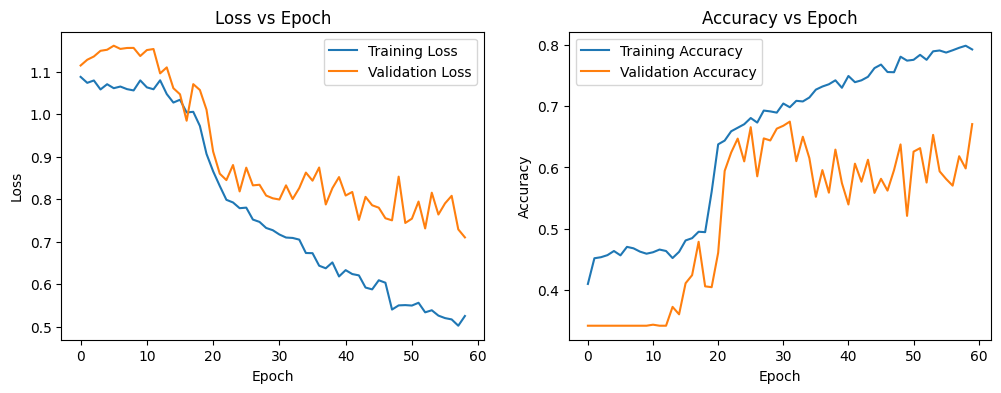

ValueError: Found input variables with inconsistent numbers of samples: [1182, 2953]

In [4]:
# Verilerin şekillendirilmesi
X_padded = X_padded[..., np.newaxis]  # (num_samples, height, width, channels)
input_shape = X_padded[0].shape

# Cross-validation ve model eğitimi
kf = KFold(n_splits=2, shuffle=True, random_state=42)
fold = 1
evaluation_metrics = []

for train_index, test_index in kf.split(X_padded):
    X_train_fold, X_test_fold = X_padded[train_index], X_padded[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    model = create_cnn_model(input_shape)

    history = model.fit(X_train_fold, y_train_fold, epochs=60, validation_data=(X_test_fold, y_test_fold), verbose=2)

    y_pred = model.predict(X_test_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = accuracy_score(y_test_fold, y_pred_classes)
    f1 = f1_score(y_test_fold, y_pred_classes, average='macro')
    recall = recall_score(y_test_fold, y_pred_classes, average='macro')
    precision = precision_score(y_test_fold, y_pred_classes, average='macro')
    mcc = matthews_corrcoef(y_test_fold, y_pred_classes)

    fpr, tpr, _ = roc_curve(y_test_fold, y_pred_classes, pos_label=1)
    roc_auc = auc(fpr, tpr)

    evaluation_metrics.append([acc, f1, recall, precision, mcc, roc_auc])

    fold += 1

# Ortalama metriklerin raporlanması
evaluation_metrics = np.array(evaluation_metrics)
mean_metrics = evaluation_metrics.mean(axis=0)
std_metrics = evaluation_metrics.std(axis=0)
metrics_names = ['Accuracy', 'F-measure', 'Recall', 'Precision', 'MCC', 'AUC']

print("Mean Evaluation Metrics:")
for name, mean, std in zip(metrics_names, mean_metrics, std_metrics):
    print(f"{name}: {mean:.4f} ± {std:.4f}")

# Training loss and accuracy plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ROC curve plotting for multiclass classification
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
roc_auc = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovr')

# Print the ROC AUC score
print("ROC AUC Score (Macro):", roc_auc)
